### Download hand gesture detection model from Hagging Face

In [1]:
! git clone https://huggingface.co/lewiswatson/yolov8x-tuned-hand-gestures

fatal: destination path 'yolov8x-tuned-hand-gestures' already exists and is not an empty directory.


### Download Helper Function Script for Notebooks (from OpenVINO)

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests
r = requests.get(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py',
)

open('notebook_utils.py', 'w').write(r.text)

from notebook_utils import download_file, VideoPlayer

### Helper Functions for drawing boxes

In [3]:
from typing import Tuple, Dict
import cv2
import numpy as np
from ultralytics.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray,
                 color:Tuple[int, int, int] = None,
                 label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        Image with boxes
    """
    boxes = results["det"]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

### Test Handgesture Detection on original model

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'L', 10: 'M', 11: 'N', 12: 'O', 13: 'P', 14: 'R', 15: 'S', 16: 'T', 17: 'U', 18: 'V', 19: 'W', 20: 'Y'}

image 1/1 C:\Users\intel\handenv\peace.jpg: 640x480 1 V, 879.5ms
Speed: 0.0ms preprocess, 879.5ms inference, 780.3ms postprocess per image at shape (1, 3, 640, 480)


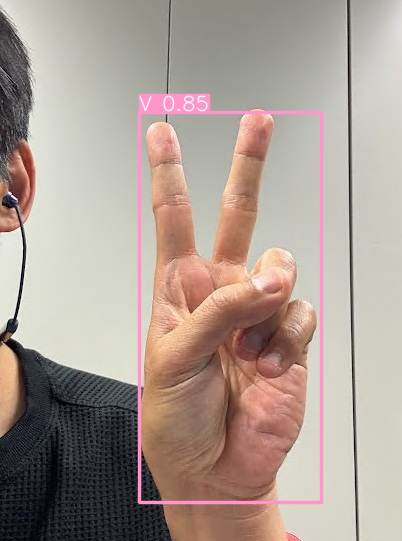

In [4]:
from PIL import Image
from ultralytics import YOLO

Path('./models').mkdir(exist_ok=True)
models_dir = Path('./models/weights')
models_dir.mkdir(exist_ok=True)
det_model = YOLO('yolov8x-tuned-hand-gestures/weights/best.pt')

label_map = det_model.model.names
print(label_map)

IMAGE_PATH = Path("./peace.jpg")
res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO

In [5]:
import shutil
import os

# object detection model folder
models_dir = Path('./models/weights')
models_dir.mkdir(exist_ok=True)
# Path for OV model
ov_convert_path = models_dir / f'ov_converted_model'

if not ov_convert_path.exists():
    det_ov_model_path = det_model.export(format="openvino", dynamic=False, half=True)
    shutil.copytree(det_ov_model_path, models_dir / f'ov_converted_model')


In [6]:
from typing import Tuple
from ultralytics.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [7]:
def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 300,
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label]
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=21,
        **nms_kwargs
    )

    results = []
    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
        results.append({"det": pred})

    return results

### Select deice: NPU or iGPU

In [8]:
import openvino as ov
core = ov.Core()
device = 'NPU' if 'NPU' in core.available_devices else 'GPU'
device

'NPU'

### Testing Hand Gesture Detection on OV Model

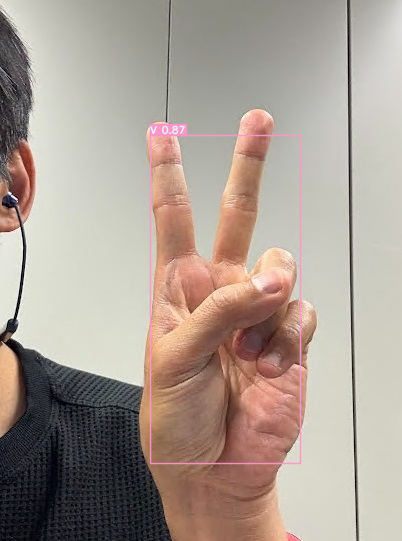

In [9]:
core = ov.Core()

#det_ov_model = core.read_model(Path(det_ov_model_path) / 'best.xml')
det_ov_model = core.read_model( models_dir / f'ov_converted_model/best.xml' )


det_ov_model.reshape({0: [1, 3, 640, 640]})
ov_config = {}
if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
det_compiled_model = core.compile_model(det_ov_model, device, ov_config)


def detect(image:np.ndarray, model:ov.Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image./
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)

    result = model(input_tensor)
    boxes = result[model.output(0)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image)
    return detections

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

### Calibration Process for Quantization
It may takes longer time to download files. 
- val2017.zip 778MB
- coco2017label-segments.zip 168MB

In [10]:
from zipfile import ZipFile

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/8ebe94d1e928687feaa1fee6d5668987df5e43be/ultralytics/datasets/coco.yaml"

OUT_DIR = Path('./datasets')

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'datasets\val2017.zip' already exists.
'datasets\coco2017labels-segments.zip' already exists.


datasets\coco.yaml:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

In [11]:
from tqdm.notebook import tqdm
from ultralytics.utils.metrics import ConfusionMatrix


def test(model:ov.Model, core:ov.Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        preds = torch.from_numpy(results[compiled_model.output(0)])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        # Print results
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

In [12]:
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.utils import check_det_dataset
from ultralytics.models.yolo.detect import DetectionValidator
from ultralytics.data.converter import coco80_to_coco91_class
# from ultralytics.models.yolo.detect import DetectionValidator
# Line 43

args = get_cfg(cfg=DEFAULT_CFG)

args.data = str(CFG_PATH)
det_validator = DetectionValidator(args=args)
det_validator.stride=1
det_validator.data = check_det_dataset(args.data)

det_data_loader = det_validator.get_dataloader("datasets/coco", 1)
det_validator.is_coco = True
det_validator.class_map = coco80_to_coco91_class()
det_validator.names = det_model.model.names
det_validator.metrics.names = det_validator.names
det_validator.nc = det_model.model.model[-1].nc

val: Scanning datasets\coco\labels\val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 


### Quantize the OV model

In [13]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


In [14]:
from openvino.runtime import serialize

# Detection model
ov_int8_path = models_dir / f'ov_int8_model'
if not ov_int8_path.exists():
    quantized_det_model = nncf.quantize(
        det_ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
    )


    ov_int8_det_model_path = ov_int8_path / f'best.xml'
    print(f"Quantized detection model will be saved to {ov_int8_det_model_path}")
    serialize(quantized_det_model, str(ov_int8_det_model_path))
else:
    quantized_det_model = core.read_model(ov_int8_path / f'best.xml')

### Test Hand Gesture on Quantized Model

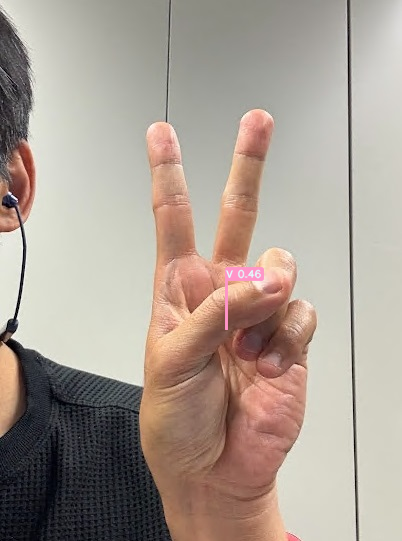

In [15]:

quantized_det_model.reshape({0: [1, 3, 640, 640]})
ov_config = {}
if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_det_compiled_model = core.compile_model(quantized_det_model, device, ov_config)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

### Sample for Controling Window via Hand Gesture

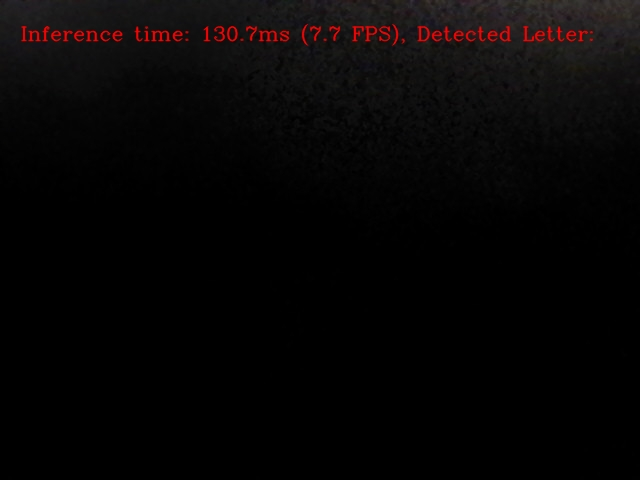

Source ended


In [20]:
import collections
import time
import pyautogui
from IPython import display

def start_menu():
    pyautogui.hotkey('win', 'tab')
def go_right():
    pyautogui.press('right')
def go_down():
    pyautogui.press('down')
def cancel():
    pyautogui.hotkey('win', 'tab')
def enter():
    pyautogui.press('enter')

# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_model, device=device):

    letters = ["0", "0", "0"]
    hit   = ["0", "0"]
    in_menu = False
    counter = 0

    
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    ov_config = {}
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()

        while True:
            detect_letter = ""
            if counter > 5 and in_menu:
                cancel()
                in_menu = False
                counter = 0
            time.sleep(0.3)
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            #label = f'{label_map[int(lbl)]} {conf:.2f}'
            if len(detections["det"]) != 0:
                counter = 0
                #print("*", label_map[int(detections["det"][0][5])])
                #print(letters)
                cur_let = label_map[int(detections["det"][0][5])]
                if cur_let == 'A':
                    continue
                if letters[-1] == cur_let and letters[-2] == cur_let:
                    #print("## ", cur_let)
                    hit.append(cur_let)
                    hit = hit[1:]
                    if in_menu:
                        if hit[-1] == 'H':
                            detect_letter = "H"
                            go_right()
                            time.sleep(0.5)
                        if hit[-1] == 'O':
                            detect_letter = "O"
                            go_down()
                            time.sleep(0.5)
                        if hit[-1] == 'V':
                            detect_letter = "V"
                            enter()
                            processing_times = collections.deque()
                            letters = ["0", "0", "0"]
                            hit   = ["0", "0"]
                            in_menu = False
                            counter = 0
                        if hit[-1] == 'W':
                            
                            detect_letter = "W"
                            cancel()
                            processing_times = collections.deque()
                            letters = ["0", "0", "0"]
                            hit   = ["0", "0"]
                            in_menu = False
                            counter = 0
                            time.sleep(2)
                    else:
                        if hit == ['U', 'U']:
                            detect_letter = "U"
                            start_menu()
                            in_menu = True
                            #time.sleep(1)
                        if hit == ['O', 'O']:
                            detect_letter = "O"
                            break
                      
                letters.append(cur_let)
                letters = letters[1:]
            else:
                counter += 1

            frame = image_with_boxes

           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            f_height, f_width = frame.shape[:2]
            # Mean processing time [ms].

            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS), Detected Letter: {detect_letter}",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()


run_object_detection(source=0, flip=True, use_popup=False, model=det_ov_model, device=device)